In [62]:
from functools import partial
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.stats import multivariate_normal as normal
%matplotlib inline
np.random.seed(1)

In [63]:
EPSILON=1e-6
MOMENTUM=0.99
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [64]:
def f_8d(vec):
    temp=np.exp(vec[:,0])*np.cos(2.0*np.pi*vec[:,1])+8.0*vec[:,2]*(vec[:,3]-0.5)**2.0 + vec[:,4]+np.log(2.0+vec[:,5])+vec[:,6]**2.0+2.0*vec[:,7]
    return temp

In [65]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=8)
X = sampler.random(n=10000)

In [66]:
from sklearn.preprocessing import MinMaxScaler
y=f_8d(X)
noise = np.random.normal(0, 1, size=(y.shape))
y=y+noise*0.2
y = y.astype(np.float32)
X=torch.tensor(X,dtype=torch.float32, requires_grad=True)

In [76]:
def unitcut(X,value,slot):
    dims=X.shape[0]
    temp=torch.ones((dims,X.shape[1]))*value
    temp[:,slot]=X[:,slot]
    return temp.cpu().detach().numpy()

def plot_8d(Xin, value_vec, f_in):
    noisey = np.random.normal(0, 1, size=(Xin.shape))
    X_var0=unitcut(Xin,value_vec[0],0); y0_var=f_in(X_var0); y0_var=y0_var+noisey[:,0]*0.2
    X_var1=unitcut(Xin,value_vec[1],1); y1_var=f_in(X_var1); y1_var=y1_var+noisey[:,0]*0.2
    X_var2=unitcut(Xin,value_vec[2],2); y2_var=f_in(X_var2); y2_var=y2_var+noisey[:,0]*0.2
    X_var3=unitcut(Xin,value_vec[3],3); y3_var=f_in(X_var3); y3_var=y3_var+noisey[:,0]*0.2
    
    X_var4=unitcut(Xin,value_vec[4],4); y4_var=f_in(X_var4); y4_var=y4_var+noisey[:,0]*0.2
    X_var5=unitcut(Xin,value_vec[5],5); y5_var=f_in(X_var5); y5_var=y5_var+noisey[:,0]*0.2
    X_var6=unitcut(Xin,value_vec[6],6); y6_var=f_in(X_var6); y6_var=y6_var+noisey[:,0]*0.2
    X_var7=unitcut(Xin,value_vec[7],7); y7_var=f_in(X_var7); y7_var=y7_var+noisey[:,0]*0.2
    #
    f = plt.figure(figsize=(10,10))

    f.add_subplot(421)
    plt.scatter(X_var0[:,0],y0_var)
    plt.xlabel('dimension1')
    
    #plt.subplot(222)
    f.add_subplot(422)
    plt.scatter(X_var1[:,1],y1_var)
    plt.xlabel('dimension2')
 

    f.add_subplot(423)
    plt.scatter(X_var2[:,2],y2_var)
    plt.xlabel('dimension3')
    
    f.add_subplot(424)
    plt.scatter(X_var3[:,3],y3_var)
    plt.xlabel('dimension4')

    f.add_subplot(425)
    plt.scatter(X_var4[:,4],y4_var)
    plt.xlabel('dimension5')

    f.add_subplot(426)
    plt.scatter(X_var5[:,5],y5_var)
    plt.xlabel('dimension6')

    f.add_subplot(427)
    plt.scatter(X_var6[:,6],y6_var)
    plt.xlabel('dimension7')

    f.add_subplot(428)
    plt.scatter(X_var7[:,7],y7_var)
    plt.xlabel('dimension8')

    plt.show()

  #  fig = plt.figure(figsize = (10,10))
  #  ax = plt.axes(projection='3d')
  #  ax.grid()
  #  ax.scatter(Xin[:,0].detach().numpy(), Xin[:,1].detach().numpy(), y, c = 'b', s = 50)
  #  ax.set_title('3D Scatter Plot')
  #  fig.show()
    return 

In [81]:
value_vec=[0.5,0.1,0.8,0.4, 0.3,0.1,0.2,0.8 ]

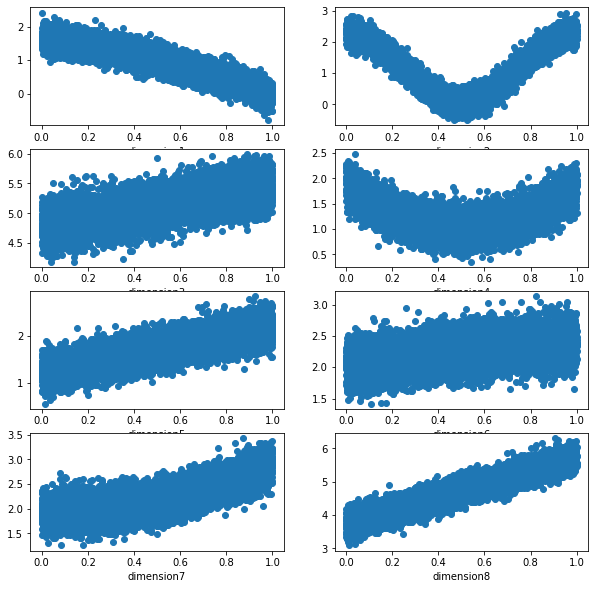

In [83]:
plot_8d(X, value_vec, f_8d)

In [84]:
ll=unitcut(X,value_vec[0],0)
ss=f_8d(ll)

In [85]:
class Config(object):
    Ntime=5 ## There are four snn parts 
    
    dim=128
    
    x_dim=8; 
    y_dim=1; 
    
    logging_frequency = 100
    verbose = True
    y_init_range = [0, 1]
    
    num_hiddens = [dim,256, dim] ## this is for each sub module
    
def get_config(name):
    try:
        return globals()[name]
    except KeyError:
        raise KeyError("config not defined.")

cfg=get_config("Config")

In [86]:
class Dense(nn.Module):
    def __init__(self,cin,cout, batch_norm=False, activate=True): 
        super(Dense, self).__init__()
        self.cin=cin
        self.cout=cout
        self.activate=activate
        self.linear=nn.Linear(self.cin, self.cout)
        
        if batch_norm:
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else:
            self.bn=None
        
    def forward(self, x):
        x=self.linear(x)
        if self.bn is not None: 
            x=self.bn(x)
        if self.activate:
            x=torch.relu(x)
        return x

class FClayerDrift(nn.Module): 
    def __init__(self,config, batch_norm=False): 
        super(FClayerDrift, self).__init__()

        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)

        self.layers=[Dense(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense(config.num_hiddens[-2], config.num_hiddens[-1], activate=False)]
        self.layers=nn.Sequential(*self.layers)
        self.dropout=nn.Dropout(0.1)
             
    def forwardX(self,x):
       # x=self.bn(x)
        x=self.layers(x) 
   #     x=self.dropout(x)
        return x   

In [87]:
class Dense2(nn.Module):
    def __init__(self,cin,cout, batch_norm=False, activate=True): 
        super(Dense2, self).__init__()
        self.cin=cin
        self.cout=cout
        self.activate=activate
        self.linear=nn.Linear(self.cin, self.cout)
        self.softplus=nn.Softplus()
        
        if batch_norm:
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else:
            self.bn=None
        
    def forward(self, x):
        x=self.linear(x)
        if self.bn is not None: 
            x=self.bn(x)
        if self.activate:
            x=torch.relu(x)
        return x

class FClayerDiffusion(nn.Module): 
    def __init__(self,config, batch_norm=False): 
        super(FClayerDiffusion, self).__init__()
        
        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)
        self.layers=[Dense2(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense2(config.num_hiddens[-2], config.num_hiddens[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
        self.dropout=nn.Dropout(0.1)
             
    def forwardX(self,x):
        #x=self.bn(x)
        x=self.layers(x) 
       # x=self.dropout(x)
        return torch.sigmoid(x)

In [88]:
loss_fn = nn.MSELoss(reduction='mean')
class SNN(nn.Module):
    def __init__(self, config, X,y, batch_size): 
        super(SNN, self).__init__()
        self.config=config
        self.X=X
        self.driftList=nn.ModuleList([FClayerDrift(self.config) for _ in range(self.config.Ntime)])
        self.diffusionList=nn.ModuleList([FClayerDiffusion(self.config) for _ in range(self.config.Ntime)])
 
        self.project0=Dense(self.config.x_dim,self.config.dim,activate=False)
        self.project_end=Dense(self.config.dim, self.config.y_dim, activate=False)
        
        self.batch_size=batch_size
        self.h=1.0/self.config.Ntime
        self.sqrth=np.sqrt(self.h)
        self.W_p=[torch.tensor(np.random.normal(0,1, (self.X.shape[0],self.config.dim)),dtype=torch.float32, requires_grad=False).to(device) for i in range(0,self.config.Ntime)]
        self.y=torch.from_numpy(y).unsqueeze(1)

    def forwardX(self,x,idx): 
      #  x=torch.tensor(x,dtype=torch.float32,requires_grad=True)
        xMat=[]
        xMat.append(x)

        x=self.project0(x)
        xMat.append(x)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*self.W_p[i][idx,:]*self.sqrth
          xMat.append(x)

        x=self.project_end(x)
        xMat.append(x)
        return xMat
      
    def backwardYZ(self,xMat,idx): ## target=
        yMat=[]
        zMat=[]

        #try to figure it later
        x_terminal=xMat[-1]
        loss=loss_fn(x_terminal,self.y[idx].to(device))
        #terminal Y_T
        y_terminal=torch.autograd.grad(outputs=[loss],inputs=[x_terminal], grad_outputs=torch.ones_like(loss), 
                                       allow_unused=True,retain_graph=True, create_graph=True)[0]
        yMat.append(y_terminal)
######## Dealing with the last layer ######## 
        xin=xMat[-2]; 
        ## here yMat[-1] is the terminal, self.project_end(xin) is also right
        hami=torch.sum(yMat[-1].detach()*self.project_end(xin),dim=1)
        ytemp=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
        yMat.append(ytemp)

####### Dealing with the middle layer
        for i in range(self.config.Ntime-1,-1,-1):
          xin=xMat[i+1]
          ztemp=yMat[-1]*self.W_p[i][idx,:]/self.sqrth #/torch.norm(self.W_p[i][idx,:], dim=1,keepdim=True)#/self.sqrth ### inverse order as well 
          zMat.append(ztemp)

## 4th layer eating x_4 (starting from 0)
          hami=torch.sum(yMat[-1].detach()*self.driftList[i].forwardX(xin)+ztemp.detach()*self.diffusionList[i].forwardX(xin),dim=1)
          ## this part requires analysis
          hami_x=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
                            
          ytemp=yMat[-1]+hami_x*self.h
          yMat.append(ytemp)

 ###### This is for the initial projection ######
        xin=xMat[0]
        hami=torch.sum(yMat[-1].detach()*self.project0(xin),dim=1)
        hami_x=torch.autograd.grad(outputs=[hami],inputs=[xin], grad_outputs=torch.ones_like(hami), 
                                    allow_unused=True,retain_graph=True, create_graph=True)[0]
        ytemp=hami_x
        yMat.append(ytemp)
        return yMat, zMat #, xMat

    def Hamcompute(self,xMat,yMat,zMat): 
        total_ham=0.0; 
        ham=torch.sum(yMat[-2].detach()*self.project0(xMat[0].detach())) ## correct
        total_ham+=ham

        for i in range(0,self.config.Ntime): 
          ham=torch.sum(yMat[self.config.Ntime-i].detach()*self.driftList[i].forwardX(xMat[i+1].detach())+zMat[i].detach()*self.diffusionList[i].forwardX(xMat[i+1].detach()))
          total_ham+=ham

        ham=torch.sum(yMat[0].detach()*self.project_end(xMat[-2].detach()))
        total_ham+=ham
        return total_ham/self.batch_size

    def predict(self,X):
        xx=X.clone()
        xMat=[]
        x=self.project0(xx)
        xMat.append(x)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*torch.FloatTensor(normal.rvs(size=[x.shape[0],self.config.dim])).to(device)*self.sqrth
          xMat.append(x)

        x=self.project_end(x)
        xMat.append(x)
        return xMat[-1]

    def predict_train(self,X):
        xx=X.clone()
        xMat=[]
        x=self.project0(xx)
        x=self.project0(X)
        for i in range(0,self.config.Ntime):
          x=x+self.driftList[i].forwardX(x)*self.h+self.diffusionList[i].forwardX(x)*self.W_p[i]*self.sqrth

        x=self.project_end(x)
        return x

In [95]:
def testf(X,value_vec):
  X_testvar0=unitcut(X,value_vec[0],0);X_testvar0=torch.tensor(X_testvar0); y_test0=model.predict(X_testvar0.to(device))#.cpu().detach().numpy()
  X_testvar1=unitcut(X,value_vec[1],1);X_testvar1=torch.tensor(X_testvar1); y_test1=model.predict(X_testvar1.to(device))#.cpu().detach().numpy()
  X_testvar2=unitcut(X,value_vec[2],2);X_testvar2=torch.tensor(X_testvar2); y_test2=model.predict(X_testvar2.to(device))#.cpu().detach().numpy()
  X_testvar3=unitcut(X,value_vec[3],3);X_testvar3=torch.tensor(X_testvar3); y_test3=model.predict(X_testvar3.to(device))
  
  X_testvar4=unitcut(X,value_vec[4],4); X_testvar4=torch.tensor(X_testvar4); y_test4=model.predict(X_testvar4.to(device))
  X_testvar5=unitcut(X,value_vec[5],5); X_testvar5=torch.tensor(X_testvar5); y_test5=model.predict(X_testvar5.to(device))
  X_testvar6=unitcut(X,value_vec[6],6); X_testvar6=torch.tensor(X_testvar6); y_test6=model.predict(X_testvar6.to(device))
  X_testvar7=unitcut(X,value_vec[7],7); X_testvar7=torch.tensor(X_testvar7); y_test7=model.predict(X_testvar7.to(device))
  
  f = plt.figure(figsize=(10,10))
  f.add_subplot(421)
  # plt.subplot(221)
  plt.scatter(X_testvar0[:,0],y_test0.cpu().detach().numpy())
  plt.xlabel('dimension1')
  
  #plt.subplot(222)
  f.add_subplot(422)
  plt.scatter(X_testvar1[:,1],y_test1.cpu().detach().numpy())
  plt.xlabel('dimension2')
  
  f.add_subplot(423)
  plt.scatter(X_testvar2[:,2],y_test2.cpu().detach().numpy())
  plt.xlabel('dimension3')
  
  f.add_subplot(424)
  plt.scatter(X_testvar3[:,3],y_test3.cpu().detach().numpy())
  plt.xlabel('dimension4')

  f.add_subplot(425)
  # plt.subplot(221)
  plt.scatter(X_testvar4[:,4],y_test4.cpu().detach().numpy())
  plt.xlabel('dimension5')
  
  #plt.subplot(222)
  f.add_subplot(426)
  plt.scatter(X_testvar5[:,5],y_test5.cpu().detach().numpy())
  plt.xlabel('dimension6')
  
  f.add_subplot(427)
  plt.scatter(X_testvar6[:,6],y_test6.cpu().detach().numpy())
  plt.xlabel('dimension7')
  
  f.add_subplot(428)
  plt.scatter(X_testvar7[:,7],y_test7.cpu().detach().numpy())
  plt.xlabel('dimension8')
  
  plt.show()
  return 

In [96]:
batch_size=256
model=SNN(cfg,X,y,batch_size).to(device);
epoch=150000; 
from torch.optim.lr_scheduler import MultiStepLR
## We see that we N=3 is kinda okay 
optimizer=torch.optim.Adam(model.parameters(), lr=1.0e-4,weight_decay=3e-8) #1e-3 too fast. use 3e-8 as decay for N=3
scheduler = MultiStepLR(optimizer, milestones=[35000,  80000], gamma=0.2) # 0.4 may be a good choice
#scheduler = MultiStepLR(optimizer, milestones=[35000, 70000], gamma=0.1)

loss_history=[]

Epoch 1000: -0.006477845832705498


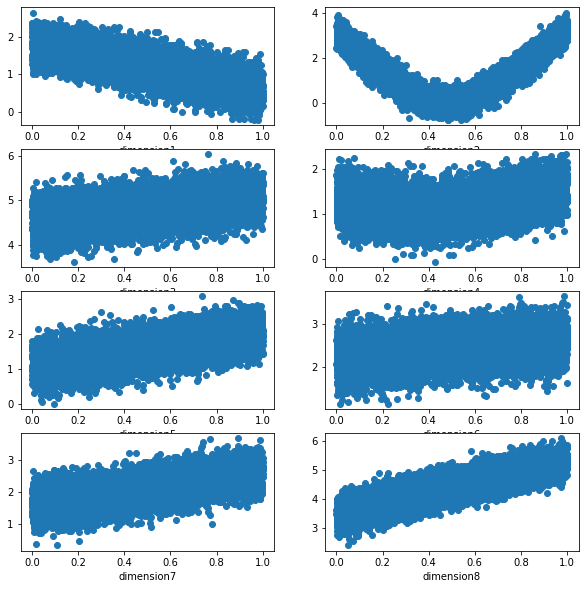

Epoch 2000: 0.013100650161504745


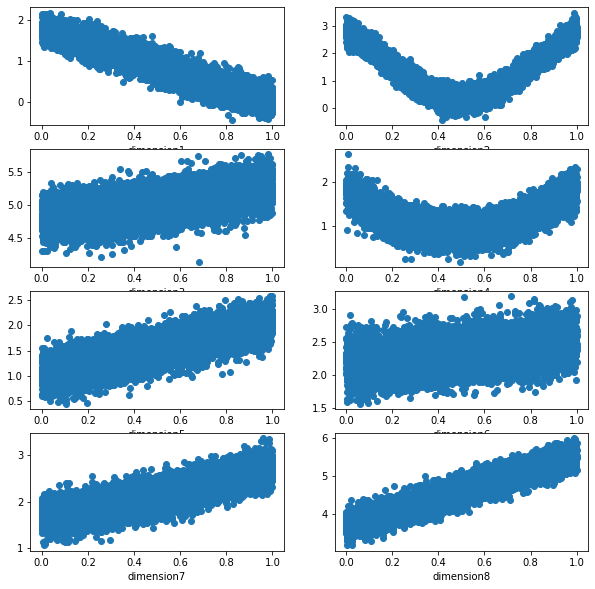

Epoch 3000: 0.0010014430154114962


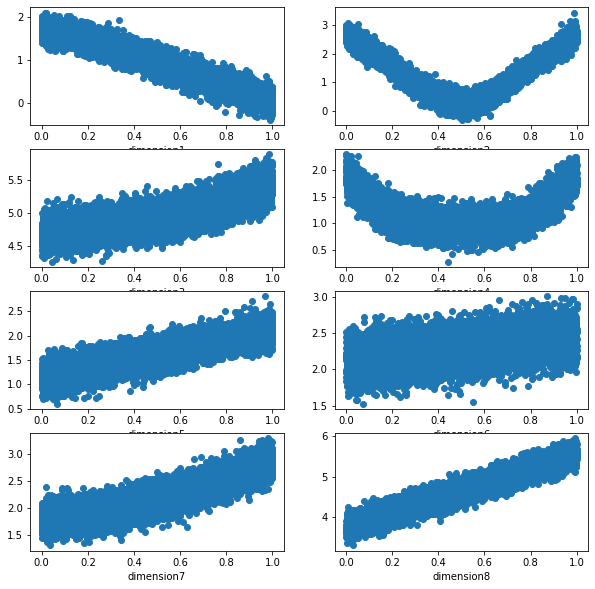

Epoch 4000: 0.0026537312660366297


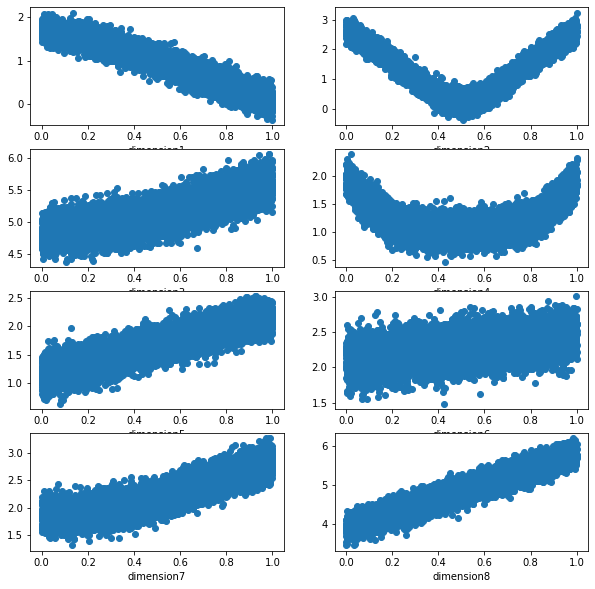

Epoch 5000: 0.0063737244345247746


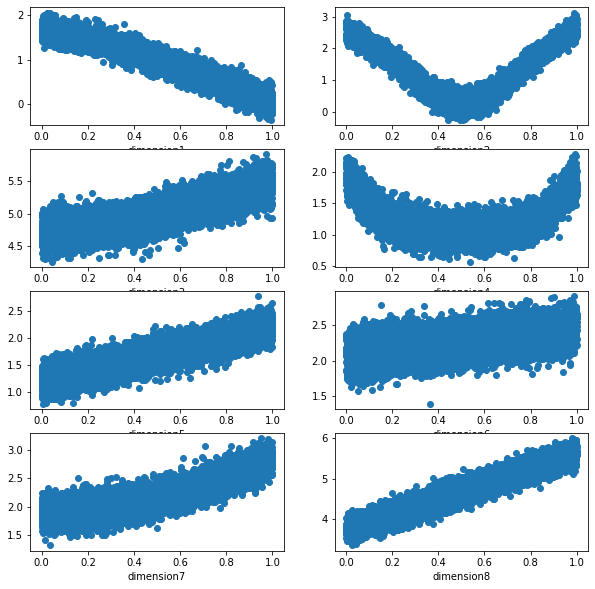

Epoch 6000: 0.0020420989021658897


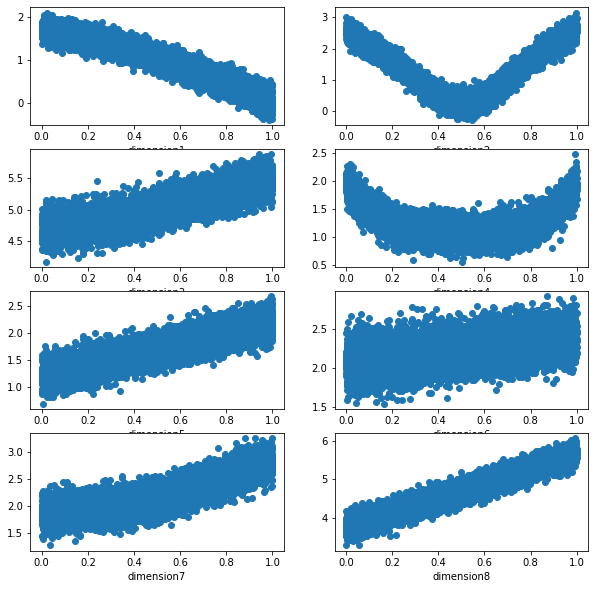

Epoch 7000: 0.0021645566448569298


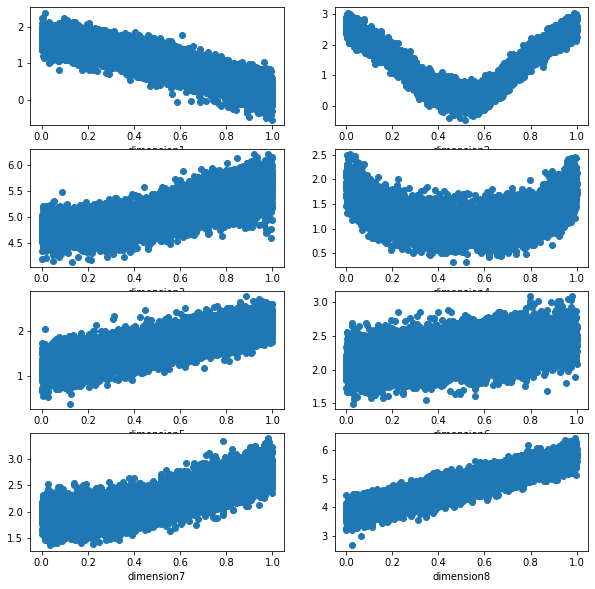

Epoch 8000: 0.0037751279305666685


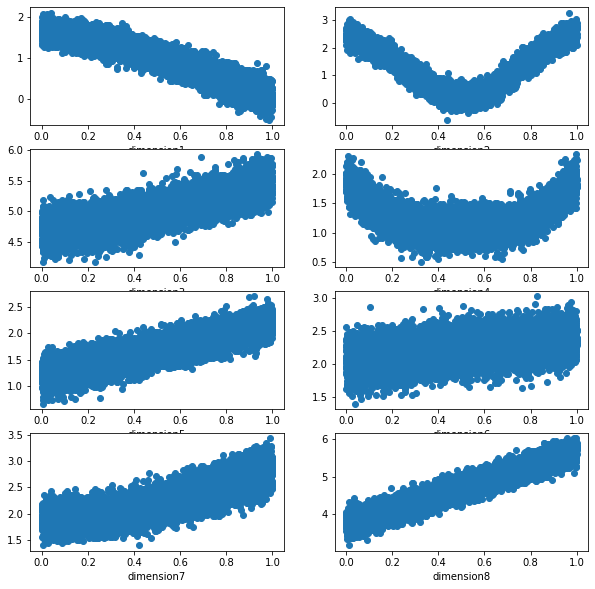

In [ ]:
for e in range(epoch): 
  shuffle_idx=np.arange(X.shape[0])
  np.random.shuffle(shuffle_idx)
  epoch_loss=[]
  
  
  optimizer.zero_grad()
  indices=np.random.randint(0, X.shape[0], size=batch_size) 
  batch_x=X[indices,:].to(device)
  
  xmat=model.forwardX(batch_x,indices)
  ymat,zmat=model.backwardYZ(xmat,indices)
  loss_temp=model.Hamcompute(xmat,ymat,zmat)

 # if grad_clip: 
 #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

  loss_temp.backward()
  optimizer.step()
  epoch_loss.append(loss_temp.cpu().detach().numpy())        
      
  epoch_loss =  np.mean(epoch_loss)
  loss_history.append(epoch_loss)
  
 
  if (e+1) % 1000 == 0:
    print("Epoch {}: {}".format(e+1, epoch_loss))  
  #  W_a=[0.2*torch.tensor(np.random.normal(0,1, (X.shape[0],cfg.dim )),dtype=torch.float32, requires_grad=False).to(device) for i in range(0,cfg.Ntime)]
  #  One can also consider less deeper layers to prevent overfitting. (coordinates, layers)
   # testf(X,value_vec)
    testf(X,value_vec)
  scheduler.step()